# Ft Lauderdale flooding

This notebook analyzes the CHIMP retrieval results for the extreme rainfall that occurred in Ft Lauderdale on April 12, 2023.

In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
lon_min, lon_max = -82, -78
lat_min, lat_max = 24, 28

We define a region of interest (ROI) centered on Ft Lauderdale with a width of 1 degree.

In [3]:
lat_fl = 26.14
lon_fl = -80.14
roi_width = 0.4

## MRMS multi-sensor QPE

In [4]:
from pansat import TimeRange
from pansat.products.ground_based import mrms

time_range = TimeRange("2023-04-12T00:00:00", "2023-04-13T00:00:00")
recs = mrms.precip_1h_ms.get(time_range)

Found table named 'satellite.goes.l1b_goes18_rad_c02_full_disk' in database but could not load find a corresponding pansat product.
Found table named 'satellite.gpm.l2a_gprof2021v1_gpm_gmi_v07c' in database but could not load find a corresponding pansat product.
Found table named 'stations.station_data' in database but could not load find a corresponding pansat product.
Found table named 'satellite.noaa.l1b_gcomw1_amsr2' in database but could not load find a corresponding pansat product.
Found table named 'dem.globe' in database but could not load find a corresponding pansat product.


In [8]:
np.cumsum(np.arange(10))

array([ 0,  1,  3,  6, 10, 15, 21, 28, 36, 45])

In [9]:
from tqdm import tqdm
sp_mrms_ms = []
for rec in tqdm(recs):
    data = mrms.precip_1h_ms.open(rec)
    lons = data.longitude.data
    lon_mask = (lon_min <= lons) * (lons <= lon_max)
    lats = data.latitude.data
    lat_mask = (lat_min <= lats) * (lats <= lat_max)
    sp_mrms_ms.append(data[{"longitude": lon_mask, "latitude": lat_mask}])

sp_mrms_ms = xr.concat(sp_mrms_ms, dim="time")

time = sp_mrms_ms.time.data
valid_time = (time > np.datetime64("2023-04-12T00:00:00")) * (time < np.datetime64("2023-04-13T01:00:00"))
results = sp_mrms_ms[{'time': valid_time}].rename(precip_1h_ms="sp_mrms")
results = results.assign_coords(time=results.time.data - np.timedelta64(1, "h"))
start_time = results.time.data[0]
end_time = results.time.data[-1]
results = results.interp(time=np.arange(start_time, end_time + np.timedelta64(1, "h"), np.timedelta64(30, "m")))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:13<00:00,  1.93it/s]


## IMERG Late

In [10]:
from pansat import TimeRange
from pansat.products.satellite.gpm import l3b_hhrl_3imerg_ms_mrg_07b

recs = l3b_hhrl_3imerg_ms_mrg_07b.get(TimeRange("2023-04-12T00:00:00", "2023-04-13T00:00:00"))
imerg_data = []
for rec in recs:
    data = l3b_hhrl_3imerg_ms_mrg_07b.open(rec.local_path)
    lons = data.longitude.data
    lon_mask = (lon_min - 0.2 <= lons) * (lons <= lon_max + 0.2)
    lats = data.latitude.data
    lat_mask = (lat_min <= lats - 0.2) * (lats <= lat_max + 0.2)
    data.surface_precipitation.attrs = {}
    data.latitude.attrs = {}
    data.longitude.attrs = {}
    data.time.attrs = {}
    imerg_data.append(data[{"latitude": lat_mask, "longitude": lon_mask}])
    
imerg_data = xr.concat(imerg_data, dim="time")
time = imerg_data.time.data
valid_time = (time >= np.datetime64("2023-04-12T00:00:00")) * (time < np.datetime64("2023-04-13T00:00:00"))
imerg_l_data = imerg_data[{'time': valid_time}].interp(longitude=results.longitude, latitude=results.latitude)
results["sp_imerg_l"] = imerg_l_data.surface_precipitation

Please enter your pansat user password:


 ········


## IMERG Final

In [11]:
from pansat import TimeRange
from pansat.products.satellite.gpm import l3b_hhr_3imerg_ms_mrg_07b

recs = l3b_hhr_3imerg_ms_mrg_07b.get(TimeRange("2023-04-12T00:00:00", "2023-04-13T00:00:00"))
imerg_data = []
for rec in recs:
    data = l3b_hhr_3imerg_ms_mrg_07b.open(rec.local_path)
    lons = data.longitude.data
    lon_mask = (lon_min - 0.2 <= lons) * (lons <= lon_max + 0.2)
    lats = data.latitude.data
    lat_mask = (lat_min <= lats - 0.2) * (lats <= lat_max + 0.2)
    data.surface_precipitation.attrs = {}
    data.latitude.attrs = {}
    data.longitude.attrs = {}
    data.time.attrs = {}
    imerg_data.append(data[{"latitude": lat_mask, "longitude": lon_mask}])
    
imerg_data = xr.concat(imerg_data, dim="time")
time = imerg_data.time.data
valid_time = (time >= np.datetime64("2023-04-12T00:00:00")) * (time < np.datetime64("2023-04-13T00:00:00"))
imerg_f_data = imerg_data[{'time': valid_time}].interp(longitude=results.longitude, latitude=results.latitude)
results["sp_imerg_f"] = imerg_f_data.surface_precipitation

## MERRA2

In [12]:
from pansat.products.reanalysis.merra import m2t1nxflx
recs = m2t1nxflx.find_files(TimeRange(np.datetime64("2023-04-12T12:00:00")))
rec = recs[0].get()
merra2_data = xr.load_dataset(rec.local_path)[["PRECTOT"]].rename(lat="latitude", lon="longitude")
merra2_data = merra2_data.interp(latitude=results.latitude, longitude=results.longitude)
merra2_data = merra2_data.interp(time=results.time)
results["sp_merra2"] = merra2_data["PRECTOT"]

# CHIMP results

In [13]:
from chimp.areas import CONUS_LATLON
from chimp.utils import get_date

models = {
    "EfficientNetV2 S": "efficient_net_s/case_study",
    "EfficientNetV2 S M": "efficient_net_s_m/case_study",
    "EfficientNetV2 S T": "efficient_net_s_t/case_study_e4",
    "EfficientNetV2 S T M": "efficient_net_s_t_m/case_study",
    "EfficientNetV2 L": "efficient_net_l/case_study",
}

chimp_results = {}

for name, path in models.items():
        
    res_files = sorted(list(Path(f"/gdata1/simon/chimp/conus_cpcir/models/{path}").glob("chimp*20230412*.nc")))
    sp = []
    for res_file in res_files:
        with xr.open_dataset(res_file) as data:
            sp_t = data[["surface_precip_mean"]]
            sp_t["time"] = (("time",), [get_date(res_file).astype('datetime64[ns]')])
            sp.append(sp_t.rename(y="latitude", x="longitude"))

    res = xr.concat(sp, dim="time")
    lons, lats = CONUS_LATLON[4].get_lonlats()
    lons = lons[0]
    lats = lats[:, 0]
    res["latitude"] = (("latitude"), lats)
    res["longitude"] = (("longitude"), lons)
    
    lon_mask = (lon_min <= lons - 0.1) * (lons <= lon_max + 0.1)
    lat_mask = (lat_min <= lats - 0.1) * (lats <= lat_max + 0.1)
    res = res[{"longitude": lon_mask, "latitude": lat_mask}].interp(latitude=results.latitude, longitude=results.longitude)
    chimp_results[name] = res.rename(surface_precip_mean="surface_precip")

In [14]:
results["sp_chimp"] = chimp_results["EfficientNetV2 S"].surface_precip
results["sp_chimp_t"] = chimp_results["EfficientNetV2 S T"].surface_precip
results["sp_chimp_m"] = chimp_results["EfficientNetV2 S M"].surface_precip
results["sp_chimp_t_m"] = chimp_results["EfficientNetV2 S T M"].surface_precip

# Plot results

Text(0.5, 0.98, 'Accumulated precipitation 2023-04-12')

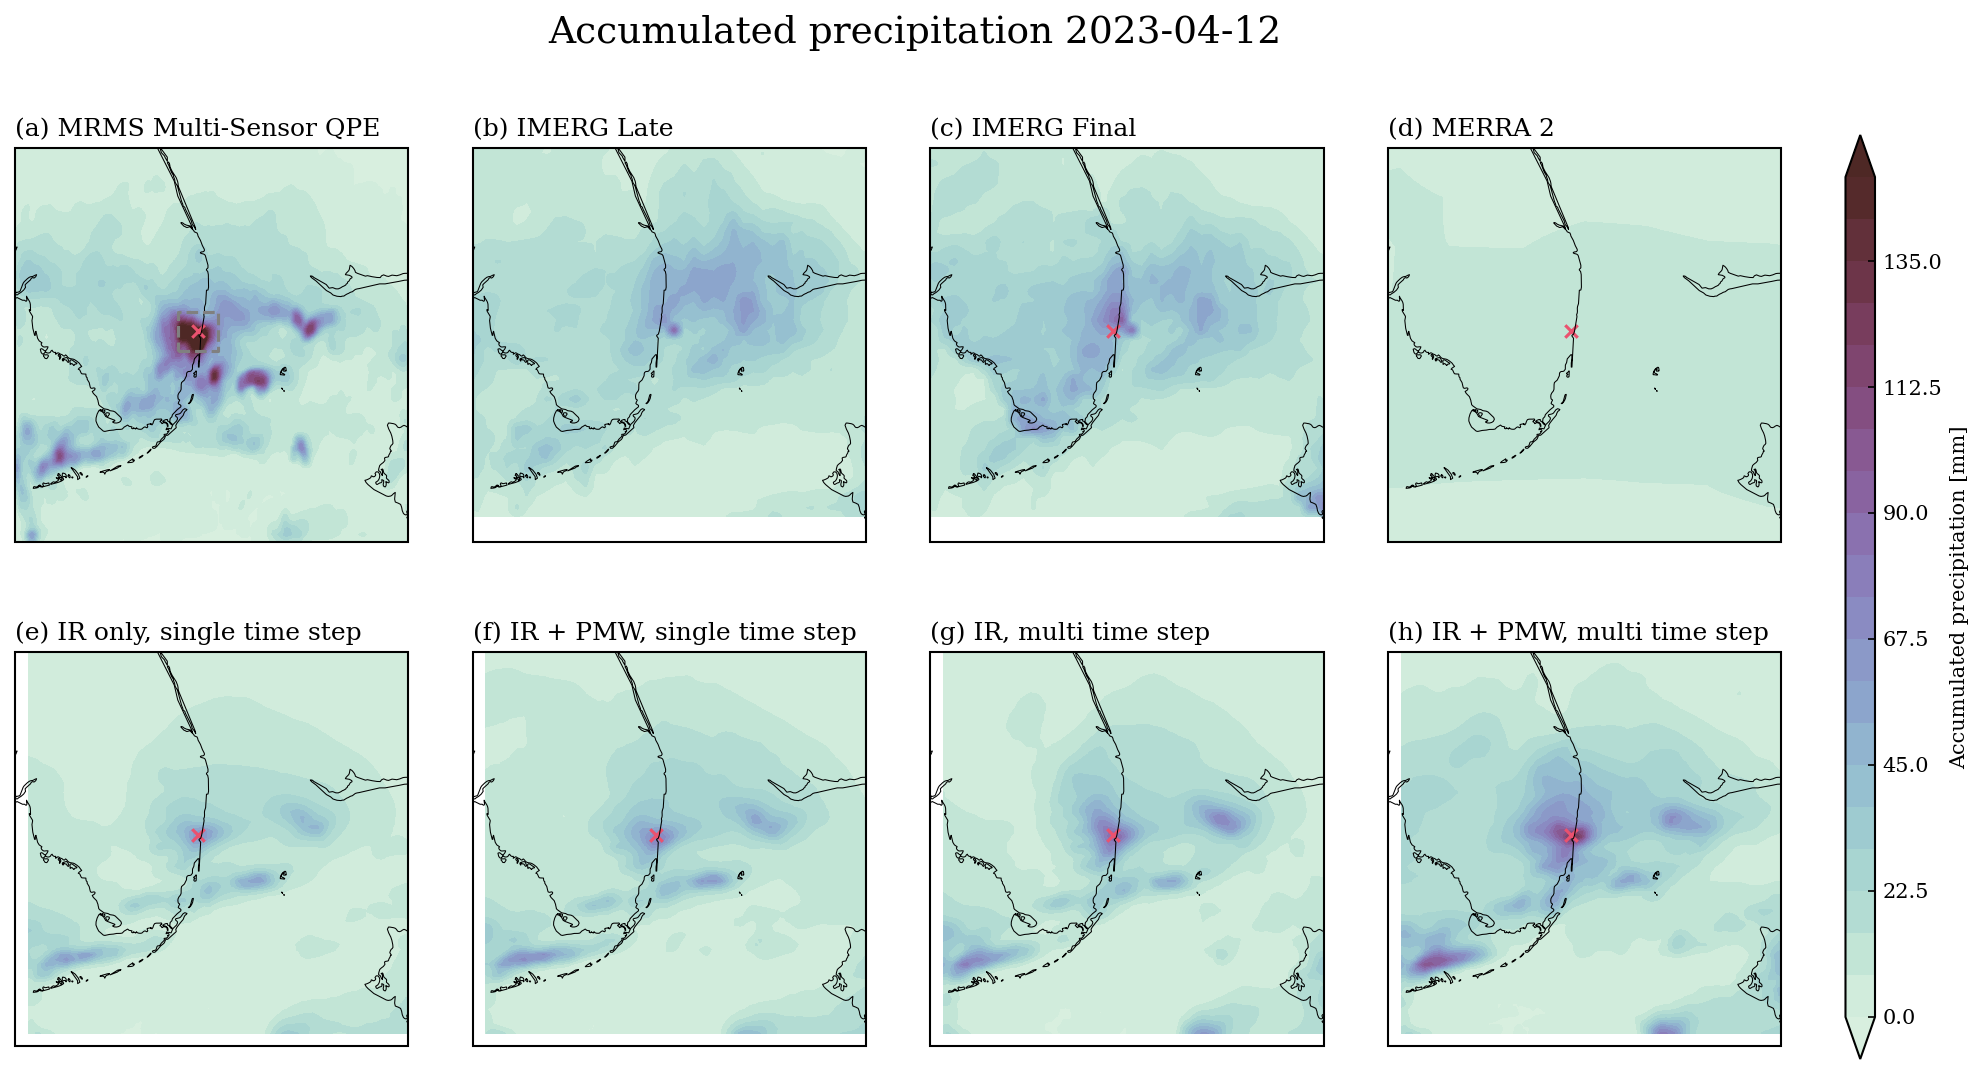

In [19]:
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from scipy.signal import convolve
from chimp.plotting import cmap_precip

sp_max = 150
norm = Normalize(0, sp_max)
levels = np.linspace(0, sp_max, 21)
levels[0] = 1e-2

x = np.linspace(-7, 7, 15)
k = np.exp(np.log(0.5) * (x / 1.8) ** 2)
k, _ = np.meshgrid(k, k)
k = k / k.sum()

fig = plt.figure(figsize=(16, 8))

gs = GridSpec(2, 5, width_ratios=[1.0, 1.0, 1.0, 1.0, 0.075])
crs = ccrs.PlateCarree()
cmap = cmap_precip

ax = fig.add_subplot(gs[0, 0], projection=crs)
lons = results.longitude.data
lats = results.latitude.data
sp = convolve((results.sp_mrms.mean("time") * 24).data, k, method="direct", mode="same")
ax.contourf(lons, lats, sp, norm=norm, levels=levels, extend="both", cmap=cmap)
ax.scatter([lon_fl], [lat_fl], c="C0", marker="x")
ax.coastlines()
ax.set_title("(a) MRMS Multi-Sensor QPE", loc="left")
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

width = roi_width / 2
ax.plot(
    [lon_fl - width, lon_fl + width, lon_fl + width, lon_fl - width, lon_fl - width],
    [lat_fl - width, lat_fl - width, lat_fl + width, lat_fl + width, lat_fl - width],
    c="grey",
    ls="--"
)

ax = fig.add_subplot(gs[0, 1], projection=crs)
lons = imerg_l_data.longitude.data
lats = imerg_l_data.latitude.data
ax.contourf(lons, lats, (imerg_l_data.surface_precipitation.mean("time") * 24).T, norm=norm, extend="both", levels=levels, cmap=cmap)
ax.set_title("(b) IMERG Late", loc="left")
ax.coastlines()
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

ax = fig.add_subplot(gs[0, 2], projection=crs)
lons = imerg_f_data.longitude.data
lats = imerg_f_data.latitude.data
m = ax.contourf(lons, lats, (imerg_f_data.surface_precipitation.mean("time") * 24).data.T, norm=norm, extend="both", levels=levels, cmap=cmap)
ax.scatter([lon_fl], [lat_fl], c="C0", marker="x")
ax.set_title("(c) IMERG Final", loc="left")
ax.coastlines()
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

ax = fig.add_subplot(gs[0, 3], projection=crs)
lons = results.longitude.data
lats = results.latitude.data
m = ax.contourf(lons, lats, results.sp_merra2.mean("time") * 24 * 3600, norm=norm, extend="both", levels=levels, cmap=cmap)
ax.scatter([lon_fl], [lat_fl], c="C0", marker="x")
ax.set_title("(d) MERRA 2", loc="left")
ax.coastlines()
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

ax = fig.add_subplot(gs[1, 0], projection=crs)
res = chimp_results["EfficientNetV2 S"].surface_precip.mean("time") * 24
lons = res.longitude.data
lats = res.latitude.data
m = ax.contourf(lons, lats, res, norm=norm, extend="both", levels=levels, cmap=cmap)
ax.scatter([lon_fl], [lat_fl], c="C0", marker="x")
ax.set_title("(e) IR only, single time step", loc="left")
ax.coastlines()
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

ax = fig.add_subplot(gs[1, 1], projection=crs)
res = chimp_results["EfficientNetV2 S M"].surface_precip.mean("time") * 24
lons = res.longitude.data
lats = res.latitude.data
m = ax.contourf(lons, lats, res, norm=norm, extend="both", levels=levels, cmap=cmap)
ax.scatter([lon_fl], [lat_fl], c="C0", marker="x")
ax.set_title("(f) IR + PMW, single time step", loc="left")
ax.coastlines()
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

ax = fig.add_subplot(gs[1, 2], projection=crs)
res = chimp_results["EfficientNetV2 S T"].surface_precip.mean("time") * 24
lons = res.longitude.data
lats = res.latitude.data
m = ax.contourf(lons, lats, res, norm=norm, extend="both", levels=levels, cmap=cmap)
ax.scatter([lon_fl], [lat_fl], c="C0", marker="x")
ax.set_title("(g) IR, multi time step", loc="left")
ax.coastlines()
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)


ax = fig.add_subplot(gs[1, 3], projection=crs)
res = chimp_results["EfficientNetV2 S T M"].surface_precip.mean("time") * 24
lons = res.longitude.data
lats = res.latitude.data
m = ax.contourf(lons, lats, res, norm=norm, extend="both", levels=levels, cmap=cmap)
ax.scatter([lon_fl], [lat_fl], c="C0", marker="x")
ax.set_title("(h) IR + PMW, multi time step", loc="left")
ax.coastlines()
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

ax = fig.add_subplot(gs[:, 4])
plt.colorbar(m, label="Accumulated precipitation [mm]", cax=ax)

fig.suptitle("Accumulated precipitation 2023-04-12", fontsize=18)

Text(0.5, 0.98, '2023-04-12 20:30')

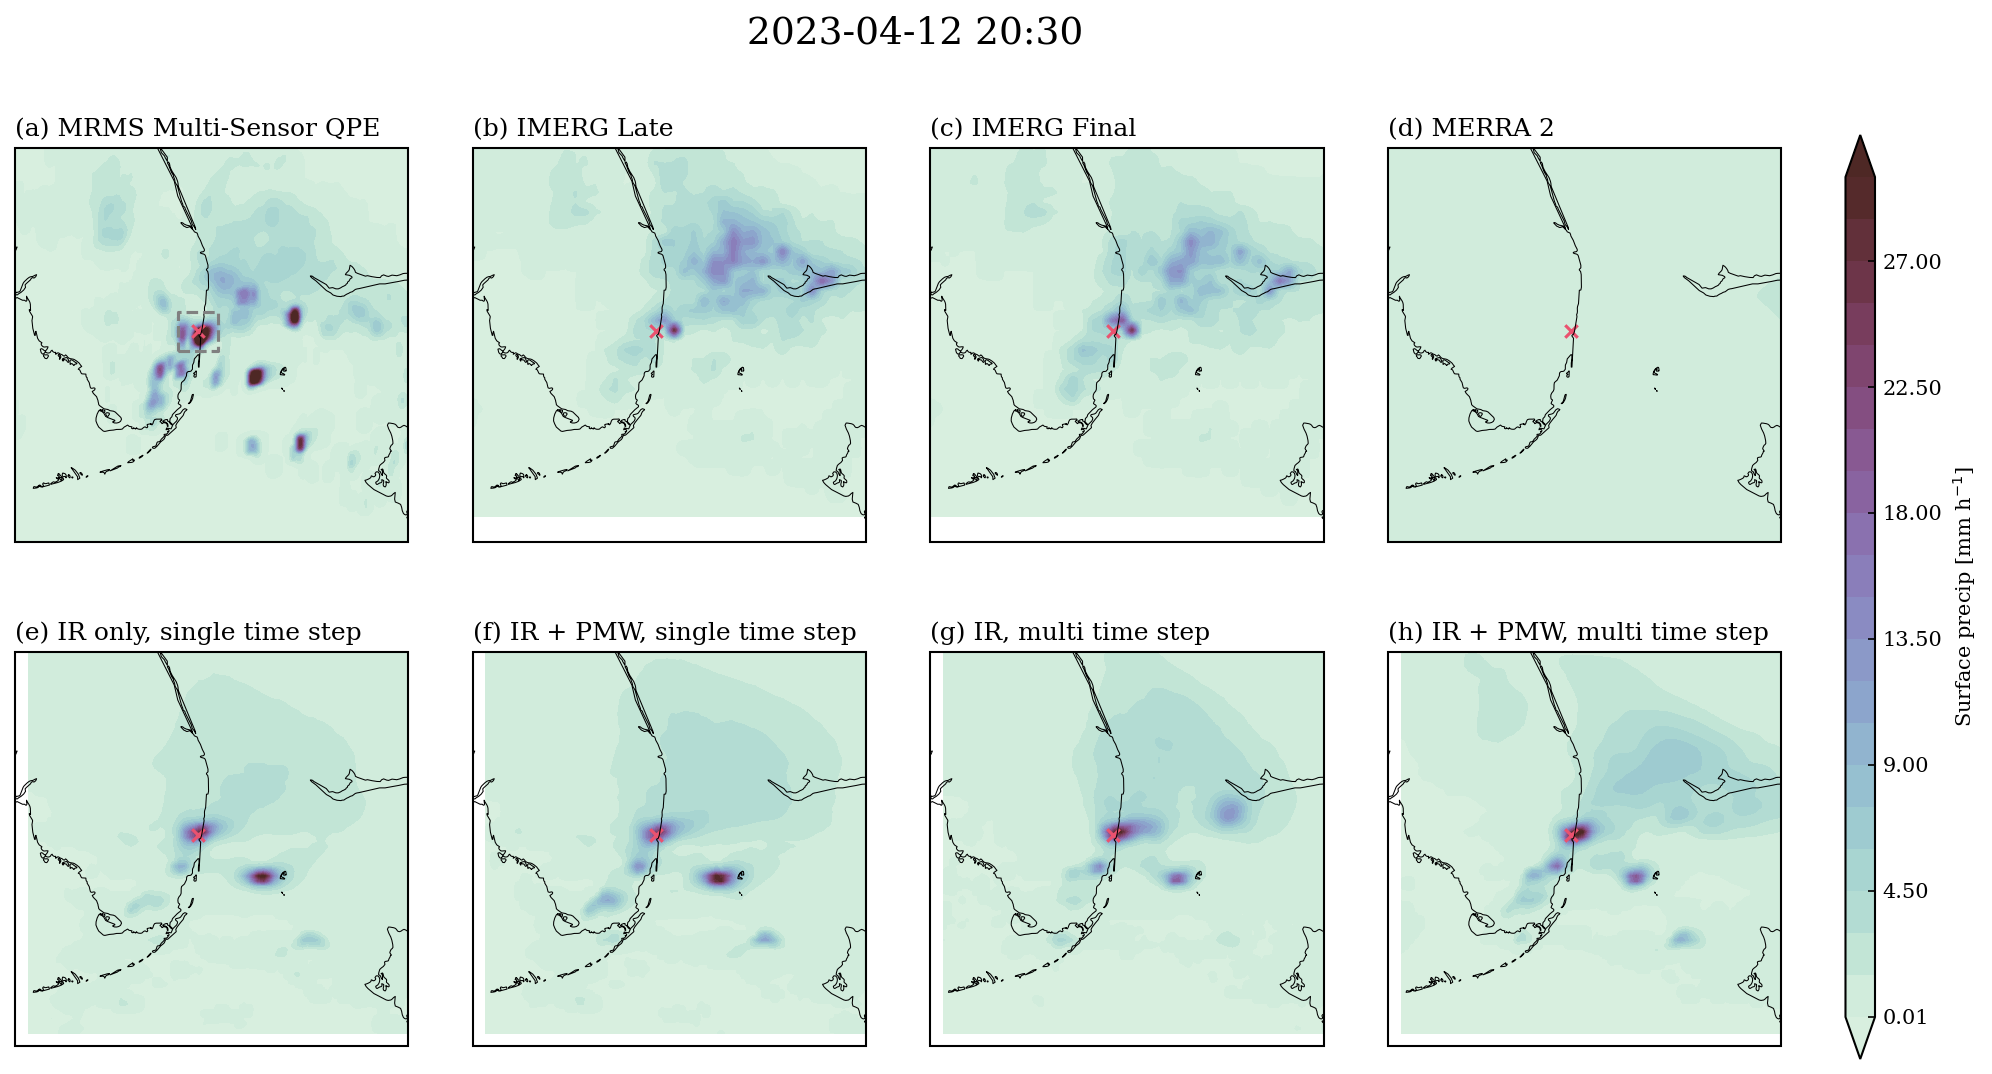

In [94]:
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from scipy.signal import convolve
from chimp.plotting import cmap_precip
from pansat.time import to_datetime

sp_max = 30
norm = Normalize(0, sp_max)
levels = np.linspace(0, sp_max, 21)
levels[0] = 1e-2
time_step = 40

x = np.linspace(-7, 7, 15)
k = np.exp(np.log(0.5) * (x / 1.8) ** 2)
k, _ = np.meshgrid(k, k)
k = k / k.sum()


fig = plt.figure(figsize=(16, 8))

gs = GridSpec(2, 5, width_ratios=[1.0, 1.0, 1.0, 1.0, 0.075])
crs = ccrs.PlateCarree()
cmap = cmap_precip

ax = fig.add_subplot(gs[0, 0], projection=crs)
lons = results.longitude.data
lats = results.latitude.data
sp = convolve(results.sp_mrms[{"time": time_step}].data, k, method="direct", mode="same")
ax.contourf(lons, lats, sp, norm=norm, levels=levels, extend="both", cmap=cmap)
ax.scatter([lon_fl], [lat_fl], c="C0", marker="x")
ax.coastlines()
ax.set_title("(a) MRMS Multi-Sensor QPE", loc="left")
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

width = roi_width / 2
ax.plot(
    [lon_fl - width, lon_fl + width, lon_fl + width, lon_fl - width, lon_fl - width],
    [lat_fl - width, lat_fl - width, lat_fl + width, lat_fl + width, lat_fl - width],
    c="grey",
    ls="--"
)

ax = fig.add_subplot(gs[0, 1], projection=crs)
lons = imerg_l_data.longitude.data
lats = imerg_l_data.latitude.data
sp = results.sp_imerg_l[{"time": time_step + 1}].transpose("latitude", "longitude").data
ax.contourf(lons, lats, sp, norm=norm, extend="both", levels=levels, cmap=cmap)
ax.set_title("(b) IMERG Late", loc="left")
ax.coastlines()
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
ax.scatter([lon_fl], [lat_fl], c="C0", marker="x")

ax = fig.add_subplot(gs[0, 2], projection=crs)
lons = imerg_f_data.longitude.data
lats = imerg_f_data.latitude.data
sp = results.sp_imerg_f[{"time": time_step + 1}].transpose("latitude", "longitude").data
m = ax.contourf(lons, lats, sp, norm=norm, extend="both", levels=levels, cmap=cmap)
ax.set_title("(c) IMERG Final", loc="left")
ax.coastlines()
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
ax.scatter([lon_fl], [lat_fl], c="C0", marker="x")

ax = fig.add_subplot(gs[0, 3], projection=crs)
lons = results.longitude.data
lats = results.latitude.data
m = ax.contourf(lons, lats, results.sp_merra2[{"time": time_step}] * 3600, norm=norm, extend="both", levels=levels, cmap=cmap)
ax.set_title("(d) MERRA 2", loc="left")
ax.coastlines()
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
ax.scatter([lon_fl], [lat_fl], c="C0", marker="x")

ax = fig.add_subplot(gs[1, 0], projection=crs)
res = results["sp_chimp"][{"time": time_step + 1}]
lons = res.longitude.data
lats = res.latitude.data
m = ax.contourf(lons, lats, res, norm=norm, extend="both", levels=levels, cmap=cmap)
ax.set_title("(e) IR only, single time step", loc="left")
ax.coastlines()
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
ax.scatter([lon_fl], [lat_fl], c="C0", marker="x")

ax = fig.add_subplot(gs[1, 1], projection=crs)
res = results["sp_chimp_m"][{"time": time_step + 1}]
lons = res.longitude.data
lats = res.latitude.data
m = ax.contourf(lons, lats, res, norm=norm, extend="both", levels=levels, cmap=cmap)
ax.set_title("(f) IR + PMW, single time step", loc="left")
ax.coastlines()
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
ax.scatter([lon_fl], [lat_fl], c="C0", marker="x")

ax = fig.add_subplot(gs[1, 2], projection=crs)
res = results["sp_chimp_t"][{"time": time_step + 1}]
lons = res.longitude.data
lats = res.latitude.data
m = ax.contourf(lons, lats, res, norm=norm, extend="both", levels=levels, cmap=cmap)
ax.set_title("(g) IR, multi time step", loc="left")
ax.coastlines()
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
ax.scatter([lon_fl], [lat_fl], c="C0", marker="x")


ax = fig.add_subplot(gs[1, 3], projection=crs)
res = results["sp_chimp_t_m"][{"time": time_step + 1}]
lons = res.longitude.data
lats = res.latitude.data
m = ax.contourf(lons, lats, res, norm=norm, extend="both", levels=levels, cmap=cmap)
ax.set_title("(h) IR + PMW, multi time step", loc="left")
ax.coastlines()
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
ax.scatter([lon_fl], [lat_fl], c="C0", marker="x")

ax = fig.add_subplot(gs[:, 4])
plt.colorbar(m, label="Surface precip [mm h$^{-1}$]", cax=ax)

time = to_datetime(results.time[time_step + 1].data)
fig.suptitle(time.strftime("%Y-%m-%d %H:%M"), fontsize=18)

## Time series

In [20]:
R = 3781e3
lons = results.longitude.data
lats = results.latitude.data
lon_mask =  (lon_fl - roi_width / 2 <= lons) *  (lons <= lon_fl + roi_width / 2)
lat_mask =  (lat_fl - roi_width / 2 <= lats) *  (lats <= lat_fl + roi_width / 2)

time_series = xr.Dataset({
    "sp_mrms": results.sp_mrms[{"longitude": lon_mask, "latitude": lat_mask}],
    "sp_imerg_late": results.sp_imerg_l[{"longitude": lon_mask, "latitude": lat_mask}],
    "sp_imerg_final": results.sp_imerg_f[{"longitude": lon_mask, "latitude": lat_mask}],
    "sp_merra2": results.sp_merra2[{"longitude": lon_mask, "latitude": lat_mask}],
    "sp_chimp_en": results.sp_chimp[{"longitude": lon_mask, "latitude": lat_mask}],
    "sp_chimp_en_m": results.sp_chimp_m[{"longitude": lon_mask, "latitude": lat_mask}],
    "sp_chimp_en_t": results.sp_chimp_t[{"longitude": lon_mask, "latitude": lat_mask}],
    "sp_chimp_en_t_m": results.sp_chimp_t_m[{"longitude": lon_mask, "latitude": lat_mask}]
})
    

In [21]:
from chimp.plotting import set_style
set_style()

Text(0, 0.5, 'Accumulated precipitation [mm]')

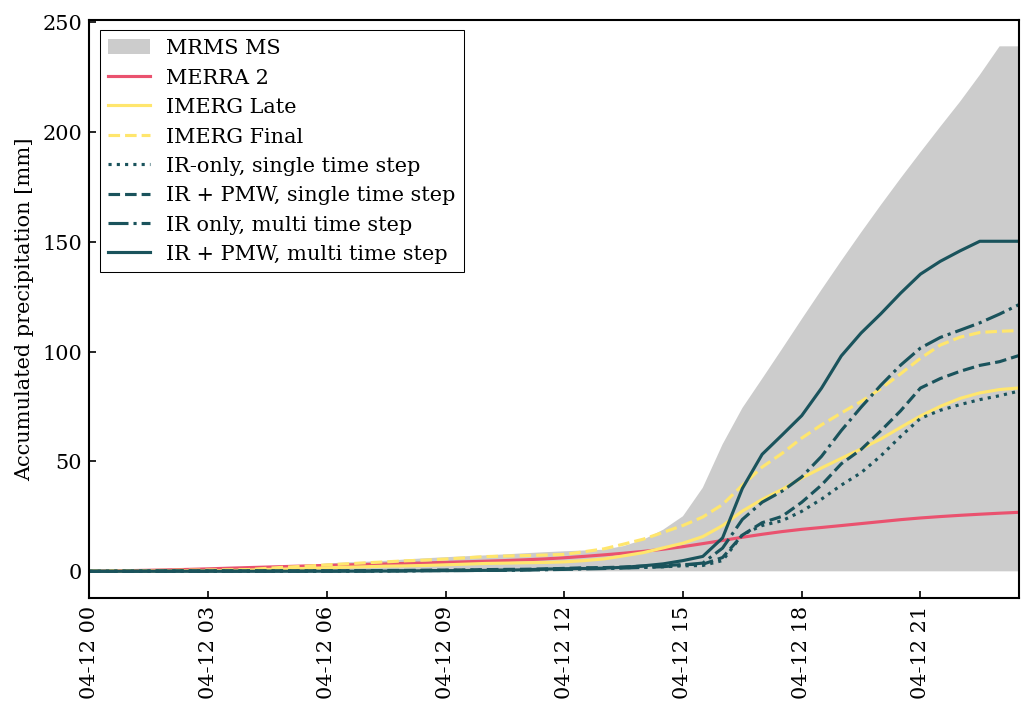

In [39]:
from matplotlib.gridspec import GridSpec

gs = GridSpec(1, 1, width_ratios=[1.0])
fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(gs[0, 0])
ax.fill_between(time_series.time, 0, np.cumsum(time_series.sp_mrms.mean(("latitude", "longitude"))), label="MRMS MS", facecolor="#CCCCCC")
ax.plot(time_series.time, np.cumsum(time_series.sp_merra2.mean(("latitude", "longitude"))) * 3600, label="MERRA 2", c="C0")
ax.plot(time_series.time, np.cumsum(time_series.sp_imerg_late.mean(("latitude", "longitude"))), label="IMERG Late", c="C4")
ax.plot(time_series.time, np.cumsum(time_series.sp_imerg_final.mean(("latitude", "longitude"))), label="IMERG Final", c="C4", ls="--")
ax.plot(time_series.time, np.cumsum(time_series.sp_chimp_en.mean(("latitude", "longitude"))), label="IR-only, single time step", c="C3", ls=":")
ax.plot(time_series.time, np.cumsum(time_series.sp_chimp_en_m.mean(("latitude", "longitude"))), label="IR + PMW, single time step", c="C3", ls="--")
ax.plot(time_series.time, np.cumsum(time_series.sp_chimp_en_t.mean(("latitude", "longitude"))), label="IR only, multi time step", c="C3", ls="-.")
ax.plot(time_series.time, np.cumsum(time_series.sp_chimp_en_t_m.mean(("latitude", "longitude"))), label="IR + PMW, multi time step", c="C3")
ax.legend()
for l in ax.xaxis.get_ticklabels():
    l.set_rotation(90)
plt.xlim(time_series.time[0], time_series.time[-1])
ax.set_ylabel("Accumulated precipitation [mm]")

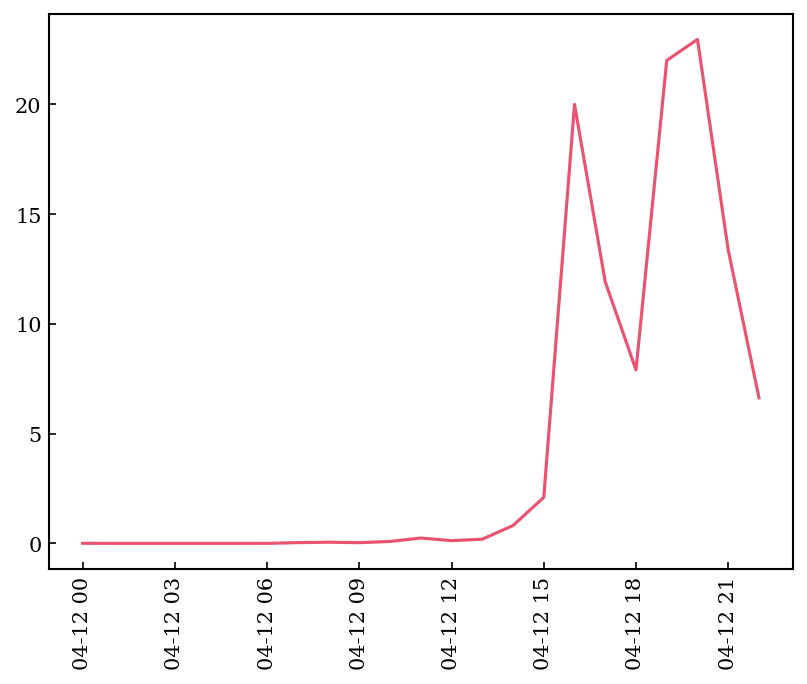

In [150]:
plt.plot(time_series.time, time_series.sp_chimp_en_t_m.mean(("latitude", "longitude")))
for l in plt.gca().xaxis.get_ticklabels():
    l.set_rotation(90)

In [153]:
res_s_t_m = xr.load_dataset("/gdata1/simon/chimp/conus_cpcir/models/efficient_net_s_t_m/test_2307.nc")
res_s = xr.load_dataset("/gdata1/simon/chimp/conus_cpcir/models/efficient_net_s/test_2307.nc")


In [162]:
res_s

<xarray.Dataset> Size: 348B
Dimensions:                               (age: 15, step: 8)
Coordinates:
  * age                                   (age) float32 60B -7.0 -6.0 ... 7.0
Dimensions without coordinates: step
Data variables:
    surface_precip_bias                   float32 4B -0.04071
    surface_precip_mse                    float32 4B 3.158
    surface_precip_correlationcoef        float32 4B 0.5233
    surface_precip_bias_cpcir             (age) float32 60B 0.06266 ... 0.02945
    surface_precip_mse_cpcir              (age) float32 60B 0.06058 ... 0.2059
    surface_precip_correlationcoef_cpcir  (age) float32 60B 0.2208 ... 0.03066
    surface_precip_bias_step              (step) float32 32B -0.04138 ... -0....
    surface_precip_mse_step               (step) float32 32B 3.191 ... 3.158
    surface_precip_correlationcoef_step   (step) float32 32B 0.5267 ... 0.5257

(<xarray.DataArray 'surface_precip_bias' ()> Size: 4B
 array(-0.04070953, dtype=float32),
 <xarray.DataArray 'surface_precip_bias' ()> Size: 4B
 array(-0.01822458, dtype=float32))

(600.0, 850.0)

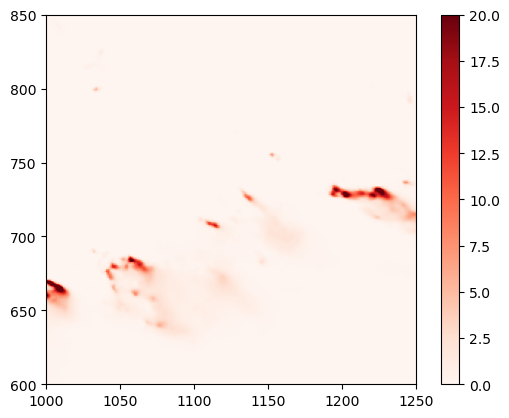

In [131]:
plt.imshow(res_en_s_t.surface_precip_mean, cmap="Reds", vmin=0, vmax=20)
plt.colorbar()
plt.xlim(1000, 1250)
plt.ylim(600, 850)

(600.0, 850.0)

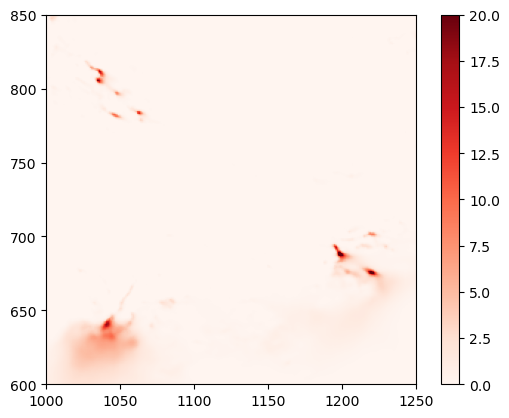

In [83]:
plt.imshow(res_en_s.surface_precip_mean, cmap="Reds", vmin=0, vmax=20)
plt.colorbar()
plt.xlim(1000, 1250)
plt.ylim(600, 850)

(600.0, 850.0)

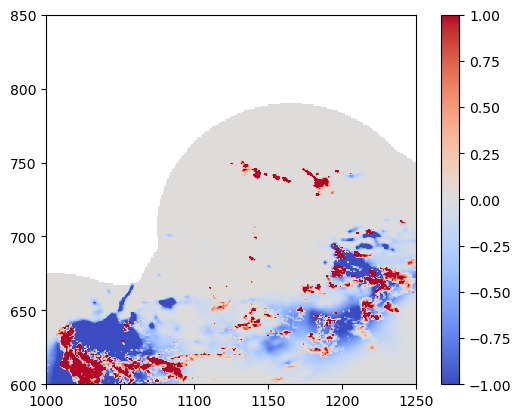

In [80]:
plt.imshow(res_ref.surface_precip - res_en_s.surface_precip_mean, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()
plt.xlim(1000, 1250)
plt.ylim(600, 850)

(600.0, 850.0)

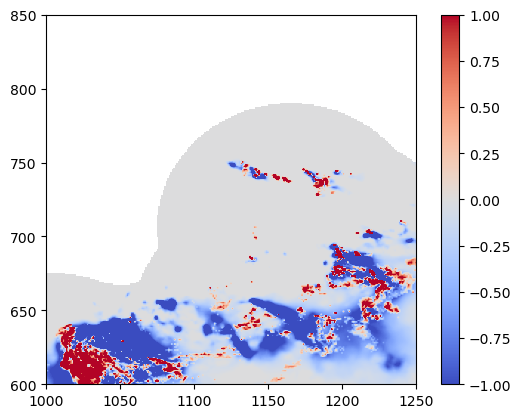

In [79]:
plt.imshow(res_ref.surface_precip - res_en_s_t.surface_precip_mean, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()
plt.xlim(1000, 1250)
plt.ylim(600, 850)

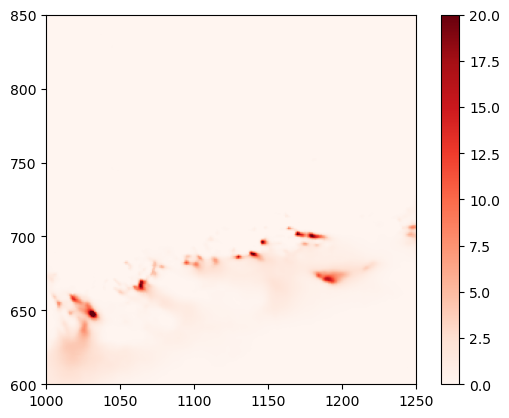

In [42]:
plt.imshow(res_en_s.surface_precip_mean, cmap="Reds", vmin=0, vmax=20)
plt.xlim(1000, 1250)
plt.ylim(600, 850)
plt.colorbar()

In [ ]:
plt.imshow(res_en_s.surface_precip_mean, cmap="Reds")
plt.xlim(1600, 1800)
plt.ylim(500, 700)
plt.colorbar()

In [ ]:
plt.pcolormesh(res_en_s_t.surface_precip_mean - res_en_s.surface_precip_mean, cmap="coolwarm", vmin=-3, vmax=3)
plt.xlim(1000, 2000)
plt.ylim(0, 1000)
plt.colorbar()

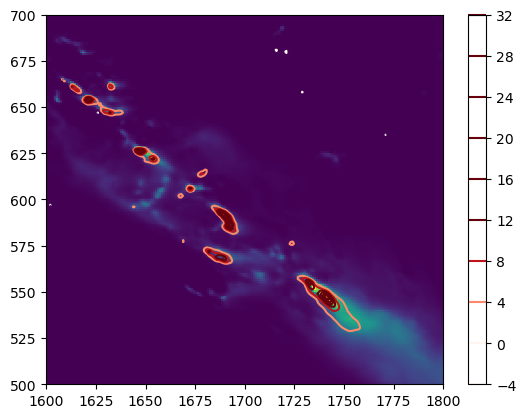

In [44]:
plt.pcolormesh(res_en_s.surface_precip_mean, vmin=0, vmax=10)
plt.contour(res_en_s_t.surface_precip_mean, cmap="Reds", vmin=0, vmax=10)
plt.xlim(1600, 1800)
plt.ylim(500, 700)
plt.colorbar()

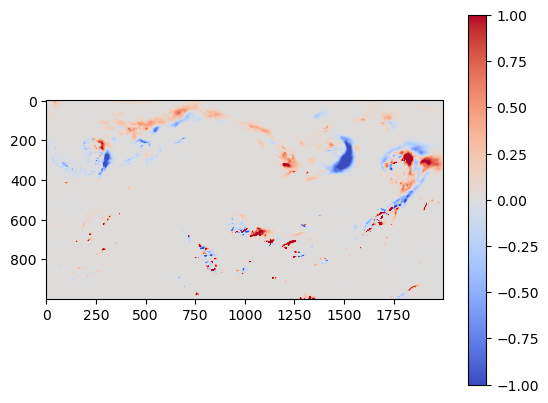

In [32]:
plt.imshow(res_en_s_t.surface_precip_mean - res_en_s.surface_precip_mean, vmin=-1.0, vmax=1.0, cmap="coolwarm")
plt.colorbar()

In [150]:
mrms_new = xr.load_dataset("/edata2/simon/chimp/conus_cpcir/training_data_new/mrms/mrms_20200101_00_00.nc")
mrms_old = xr.load_dataset("/gdata1/simon/chimp/conus_cpcir/training_data/mrms/mrms_20200101_00_00.nc")

In [151]:
diff = mrms_new.surface_precip - mrms_old.surface_precip

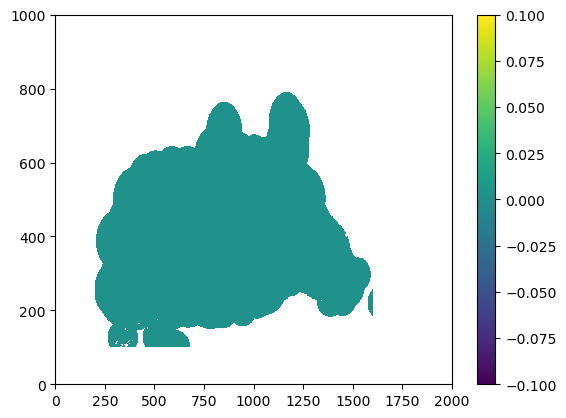

In [152]:
plt.pcolormesh(diff)
plt.colorbar()

In [153]:
diff.min()

<xarray.DataArray 'surface_precip' ()> Size: 8B
array(0.)